In [1]:
import gymnasium as gym
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import itertools

from common import *
from envs import MIMICEnv
from rl_policies import D3QNAgent, CQLAgent, IQLAgent
from ope import *

import warnings
warnings.filterwarnings('ignore')

In [2]:
# load data

sepsis_df = pd.read_csv('data/norm_sepsis_df.csv')
full_env = MIMICEnv(sepsis_df, latent=False)
latent_env = MIMICEnv(sepsis_df, latent=True)


cutoff = int(0.8 * len(sepsis_df['icustayid']))

train_ids = sepsis_df['icustayid'][:cutoff]
train_df = sepsis_df[sepsis_df['icustayid'].isin(train_ids)]

test_ids = sepsis_df['icustayid'][cutoff:]
test_df = sepsis_df[sepsis_df['icustayid'].isin(test_ids)]

In [9]:
# tools for training, evaluating, visualizing our policies


def train_policy(model, env, n_episodes=10_000, update_freq=50, verbose=True, model_name=''):
    """
    Training loop to learn a Q-function.
    """
    assert model_name in ('D3QN', 'CQL', 'IQL')
    
    rewards, lengths, q_vals = [], [], []

    for i in tqdm(range(n_episodes)):
        state = env.reset()
        done = False
        total_reward, episode_length = 0, 0

        while not done:
            action = model.select_action(state)
            next_state, reward, done, _ = env.step(action)
            model.learn(state, action, reward, next_state, done)
            
            # update for next timestep
            state = next_state
            total_reward += reward
            episode_length += 1

            # occasionally, plot the q-function as a heatmap
            if verbose and i % 1000 == 0 and np.random.rand() < 0.1:
                fig, ax = plt.subplots()
                temp_q_vals = model.get_q_values(state)
                temp_q_array = np.array(temp_q_vals).reshape((5,5))
                plot_heatmap(temp_q_array, f'{model_name} Q(s,a)', ax)
                plt.show()

        if i % update_freq == 0:
            rewards.append(total_reward)
            lengths.append(episode_length)

            # average Q(s',a) over all states in episode
            max_q_val = model.get_q_values(state).max().item()
            q_vals.append(max_q_val)

            # update the target network weights to match main network
            if model_name in ('D3QN', 'CQL'):
                model.hard_update()


    if verbose:
        fig, axs = plt.subplots(1, 3, figsize=(10, 4))

        axs[0].plot(pd.Series(rewards))
        axs[0].set_title(f'{model_name} reward per episode')
        
        axs[1].plot(pd.Series(lengths))
        axs[1].set_title(f'{model_name} episode lengths')

        axs[2].plot(pd.Series(q_vals))
        axs[2].set_title(f'{model_name} max_a Q(s,a) during training')
    

def eval_policy(model, env, n_episodes=1000, model_name=''):
    """
    Evaluate our learned policy, to see what Q-function we're learning.
    """
    q_vals = []
    action_log = np.zeros((5,5))
    
    for i in tqdm(range(n_episodes)):
        state = env.reset()
        done = False

        while not done:
            action = model.select_action(state) # NOT greedy
            next_state, reward, done, _ = env.step(action)
            
            # log action
            action_tuple = get_action_tuple(action)
            action_log[action_tuple] += 1

        if i % 10 == 0:
            # get the average q value over the episode
            max_q_val = model.get_q_values(state).max().item()
            q_vals.append(max_q_val)

    fig, axs = plt.subplots(1, 2, figsize=(10, 4))

    # visualize q function
    axs[0].plot(pd.Series(q_vals))
    axs[0].set_title('max_a Q(s,a) during eval')

    # visualize action selection
    plot_heatmap(action_log, f'{model_name} policy', axs[1])

    plt.show()

            

def plot_heatmap(array, plot_title, ax):
    """
    Visualize the frequency of actions selected by a policy, over the 2D action space.
    OR
    Visualize Q(s,a) over the 2D action space for a given state.
    """  
    sns.heatmap(array, cmap='crest', annot=True, ax=ax)

    ax.set_title(plot_title)
    ax.set_xlabel('vasopressor bin')
    ax.set_ylabel('iv bin')
    ax.invert_yaxis()
    ax.grid(which='minor', color='b', linestyle='-', linewidth=1)


100%|██████████████████████████████████████| 3308/3308 [00:05<00:00, 650.68it/s]


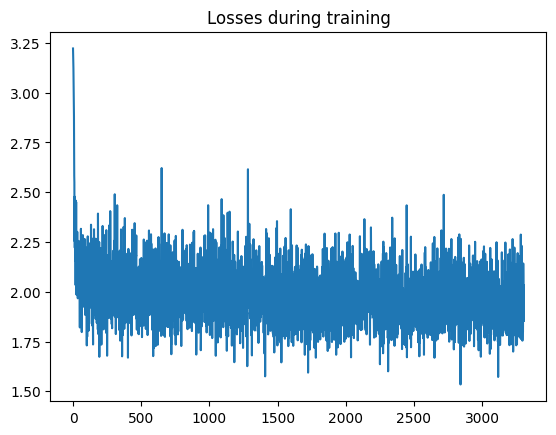

mean training loss: 1.9861824335181295


100%|██████████████████████████████████| 52921/52921 [00:04<00:00, 12198.54it/s]


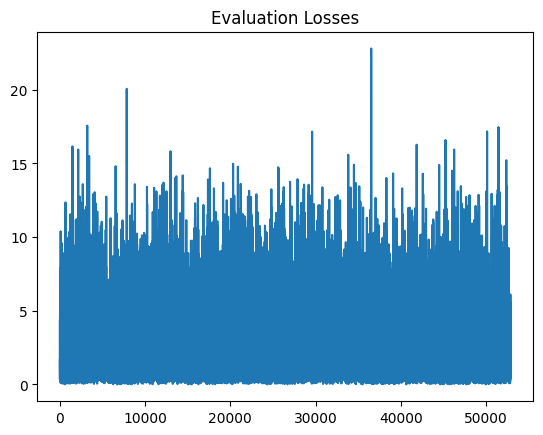

mean eval loss: 2.246364457977255


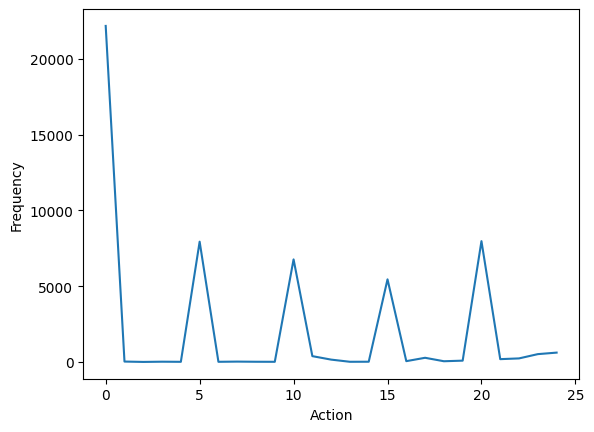

In [5]:
### DO NOT USE -- Physician policy estimation via behavioral cloning -- with latent space vectors ###

# train new policy
physician_policy_latent = compute_physician_policy(train_df, latent=True, verbose=True)
#torch.save(physician_policy.state_dict(), 'models/physician_policy.pth')

# load saved policy
#physician_policy = BehaviorPolicy(state_dim=20, action_dim=25, hidden_dim=256)
#physician_policy.load_state_dict(torch.load('models/physician_policy.pth'))

evaluate_physician_policy(physician_policy_latent, test_df, latent=True)

100%|██████████████████████████████████████| 3308/3308 [00:04<00:00, 691.86it/s]


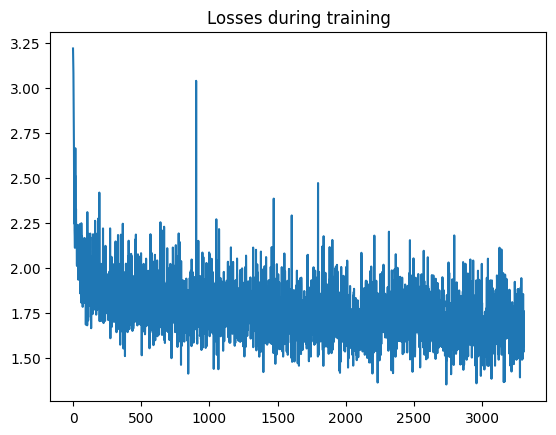

mean training loss: 1.7691881282225774


100%|██████████████████████████████████| 52921/52921 [00:04<00:00, 11806.90it/s]


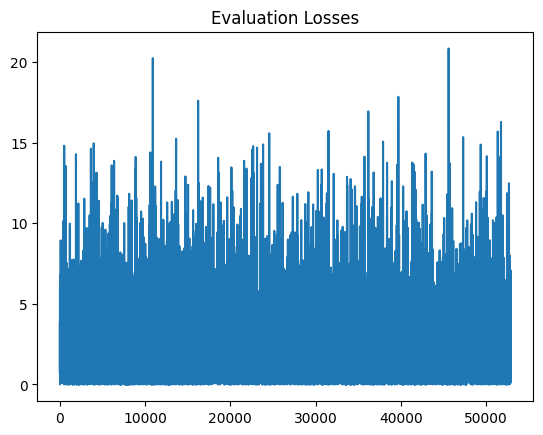

mean eval loss: 1.9247008074204315


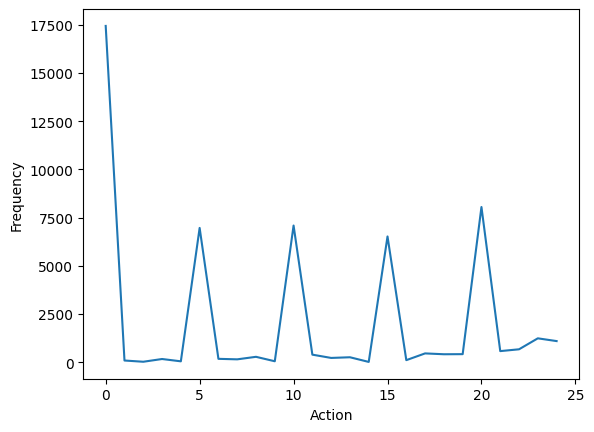

In [6]:
### Physician policy estimation via behavioral cloning -- with full state vectors ###


# train new policy
physician_policy = compute_physician_policy(train_df, verbose=True)
torch.save(physician_policy.state_dict(), 'models/physician_policy.pth')

# load saved policy
#physician_policy = BehaviorPolicy(state_dim=46, action_dim=25, hidden_dim=256)
#physician_policy.load_state_dict(torch.load('models/physician_policy.pth'))

evaluate_physician_policy(physician_policy, test_df)

In [7]:
algorithms = (D3QNAgent, CQLAgent, IQLAgent)
latent_flags = (True, False)
settings = itertools.product(algorithms, latent_flags)

data = []

for algo, latent in settings:
    env = MIMICEnv(sepsis_df, latent=latent)
    agent_policy = algo(env.obs_dim, env.action_dim)
    
    model_name = str(agent_policy.__class__)[20:-7]
    state_rep = 'latent state' if latent else 'full state'
    print(f'{model_name}, {state_rep}')
    
    train_policy(agent_policy, env, model_name=model_name, verbose=False)
    
    fqe_estimate = ope_fqe(train_df, sepsis_df, agent_policy)
    wis_estimate = ope_wis(sepsis_df, physician_policy, agent_policy)
    dr_estimate = ope_doubly_robust(train_df, sepsis_df, physician_policy, agent_policy)
    
    row = [model_name, state_rep, fqe_estimate, wis_estimate, dr_estimate]
    data.append(row)

eval_df = pd.DataFrame(data, cols=['Algorithm', 'State Rep', 'FQE', 'WIS', 'DR'])
eval_df

D3QN, latent state


  2%|▋                                      | 162/10000 [00:02<02:05, 78.12it/s]


KeyboardInterrupt: 

100%|██████████████████████████████████████| 1000/1000 [00:03<00:00, 256.41it/s]


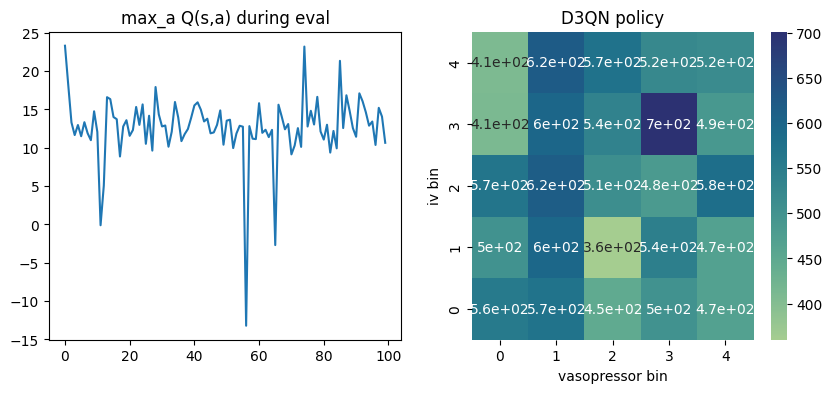

In [12]:
### Dueling Double Deep Q Networks -- with full state space ###

d3qn_full_agent = D3QNAgent(full_env.obs_dim, full_env.action_dim)

# train policy
train_policy(d3qn_full_agent, full_env, model_name='D3QN', verbose=False)

# save policy
#torch.save(d3qn_agent.main_network.state_dict(), 'models/d3qn_policy.pth')

# load policy
#d3qn_agent.main_network.load_state_dict(torch.load('models/d3qn_policy.pth'))

# evaluate policy
eval_policy(d3qn_full_agent, full_env, model_name='D3QN')

100%|██████████████████████████████████████| 1000/1000 [00:01<00:00, 562.38it/s]


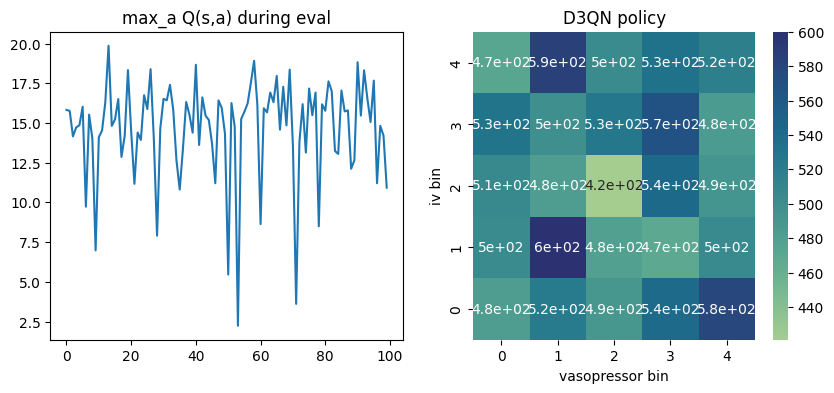

In [13]:
### Dueling Double Deep Q Networks -- with latent state space ###

d3qn_latent_agent = D3QNAgent(latent_env.obs_dim, latent_env.action_dim)

# train policy
train_policy(d3qn_latent_agent, latent_env, model_name='D3QN', verbose=False)

# save policy
#torch.save(d3qn_agent.main_network.state_dict(), 'models/d3qn_policy.pth')

# load policy
#d3qn_agent.main_network.load_state_dict(torch.load('models/d3qn_policy.pth'))

# evaluate policy
eval_policy(d3qn_latent_agent, latent_env, model_name='D3QN')

  0%|                                                 | 0/10000 [00:00<?, ?it/s]

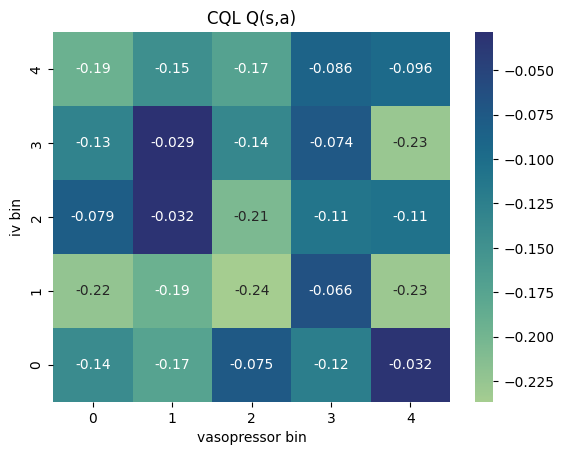

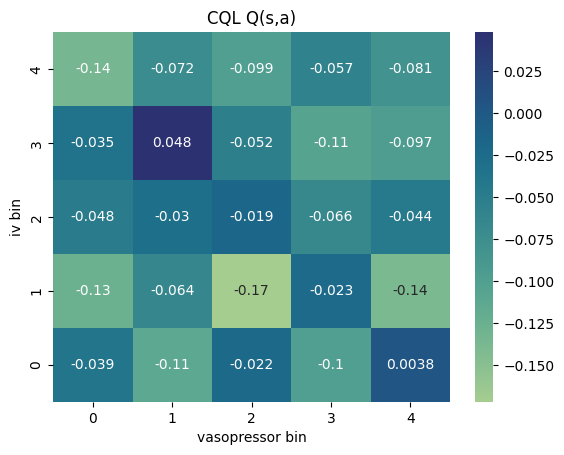

 20%|███████▌                              | 1995/10000 [00:38<02:34, 51.67it/s]

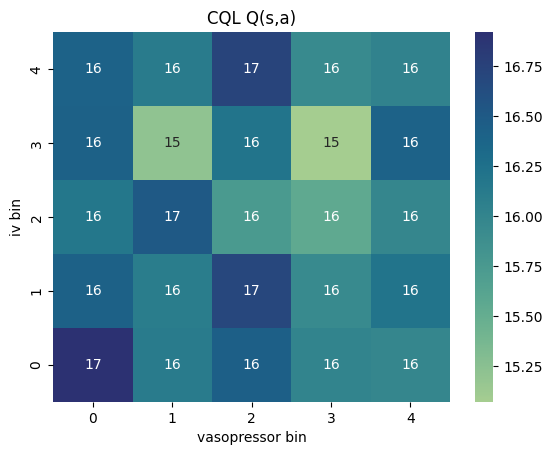

 30%|███████████▍                          | 2998/10000 [00:59<02:31, 46.12it/s]

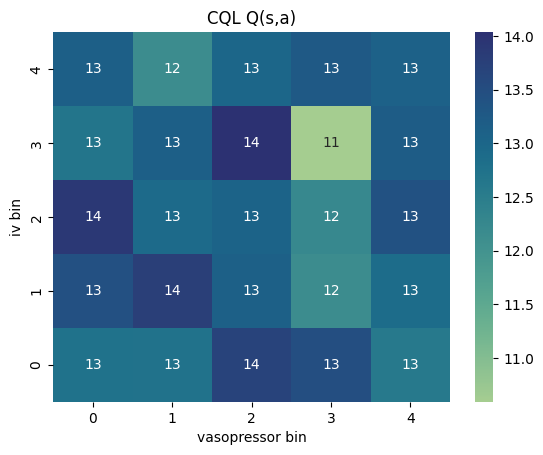

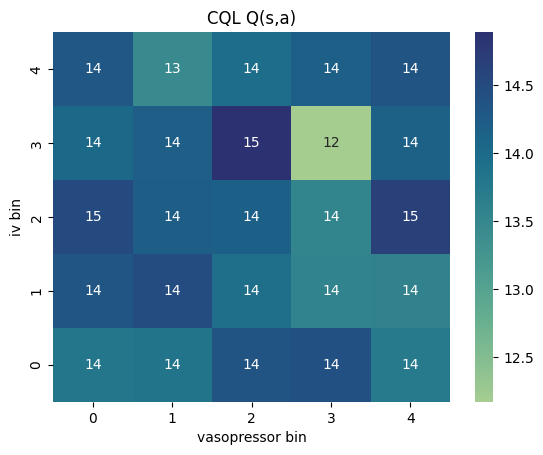

 40%|███████████████▏                      | 3996/10000 [01:18<02:25, 41.37it/s]

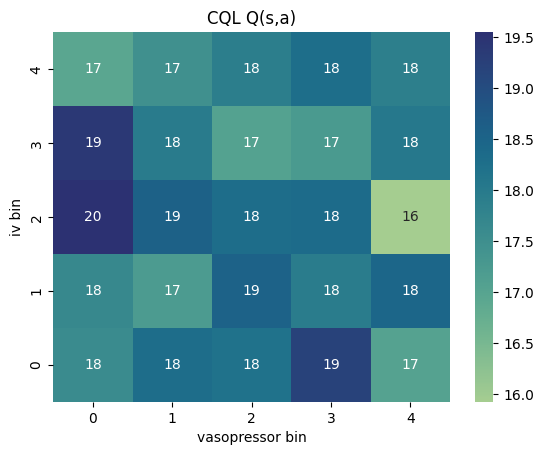

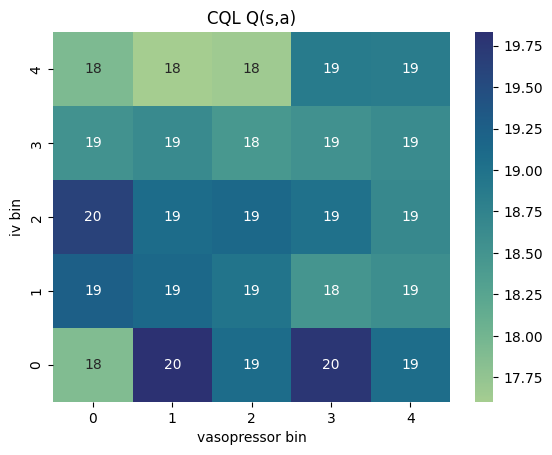

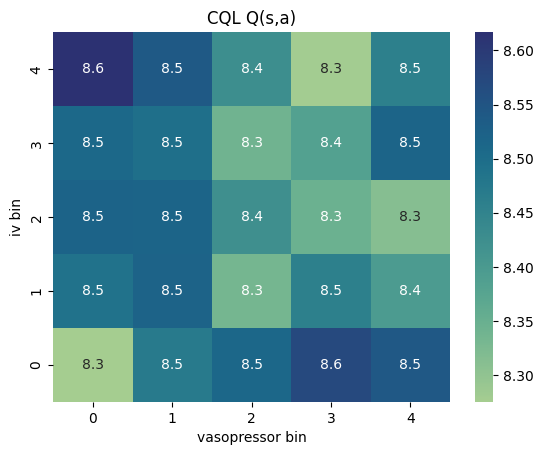

 50%|██████████████████▉                   | 4999/10000 [01:37<01:27, 57.40it/s]

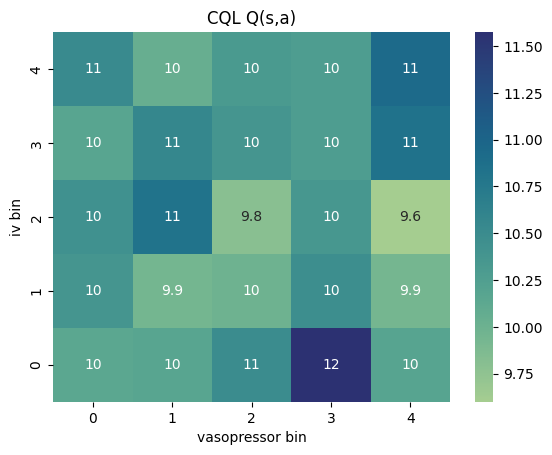

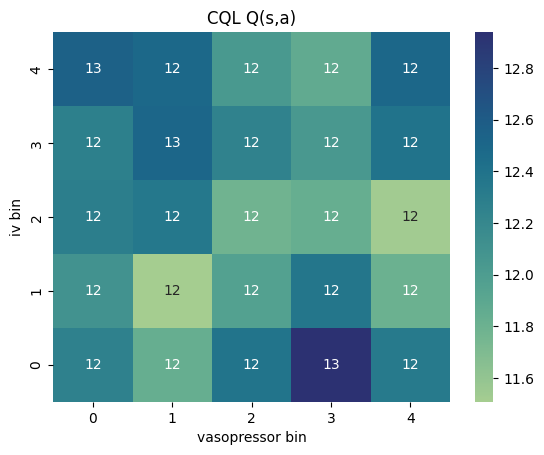

 60%|██████████████████████▊               | 5995/10000 [01:57<01:18, 51.12it/s]

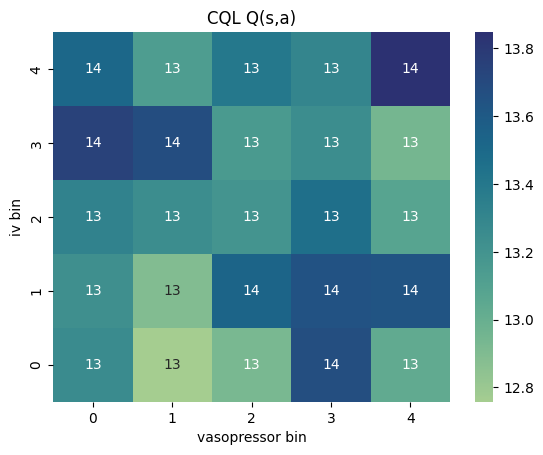

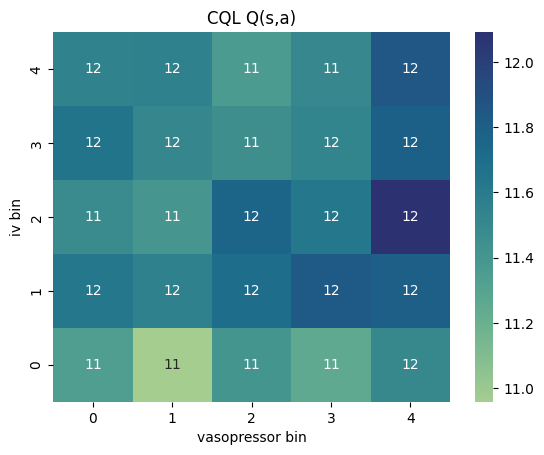

 70%|██████████████████████████▌           | 6997/10000 [03:39<01:06, 44.87it/s]

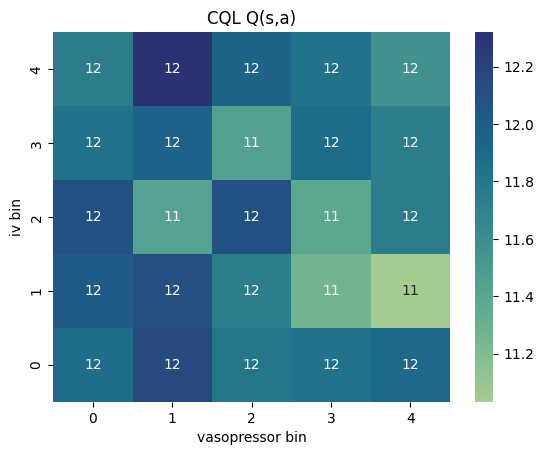

 80%|██████████████████████████████▍       | 7997/10000 [04:24<07:32,  4.43it/s]

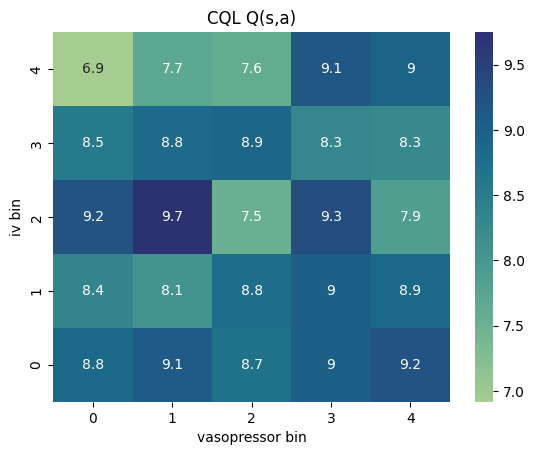

 90%|██████████████████████████████████▏   | 8996/10000 [05:16<00:19, 51.95it/s]

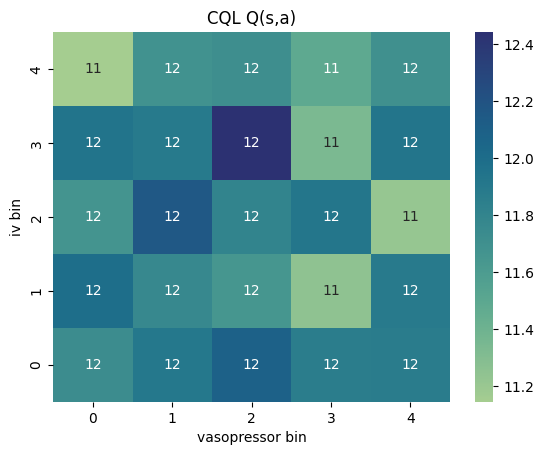

100%|██████████████████████████████████████| 1000/1000 [00:03<00:00, 270.53it/s]


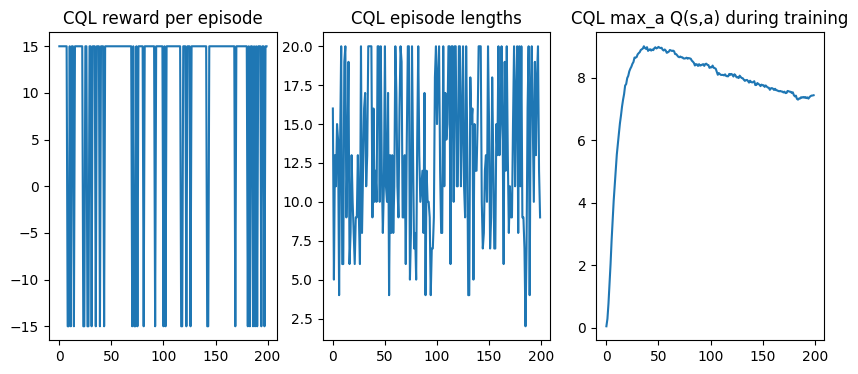

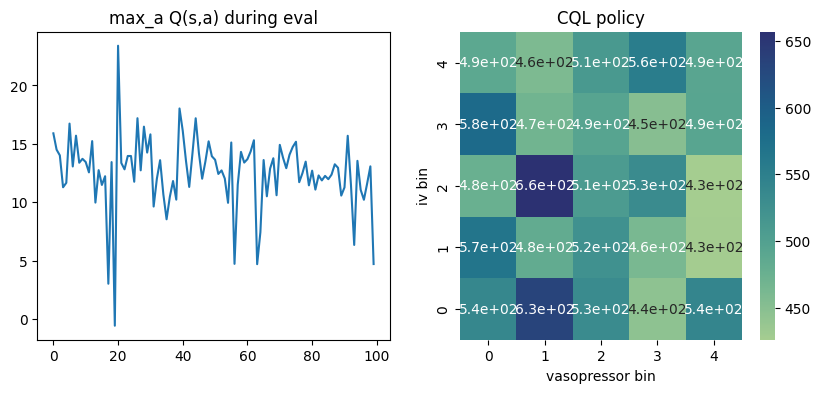

In [15]:
### Conservative Q-Learning (CQL) -- with full state space ###

cql_full_agent = CQLAgent(full_env.obs_dim, full_env.action_dim)

# train policy
train_policy(cql_full_agent, full_env, model_name='CQL')

# save policy
torch.save(cql_full_agent.main_network.state_dict(), 'models/cql_full_policy.pth')

# load policy
#cql_agent.main_network.load_state_dict(torch.load('models/cql_policy.pth'))

# evaluate policy
eval_policy(cql_full_agent, full_env, model_name='CQL')

  0%|                                                 | 0/10000 [00:00<?, ?it/s]

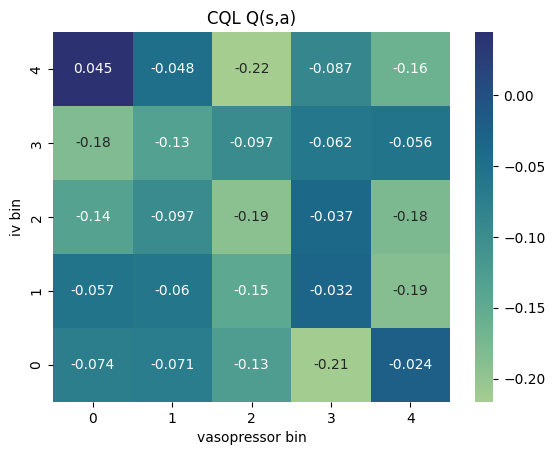

 20%|███████▌                              | 1994/10000 [18:04<03:12, 41.53it/s]

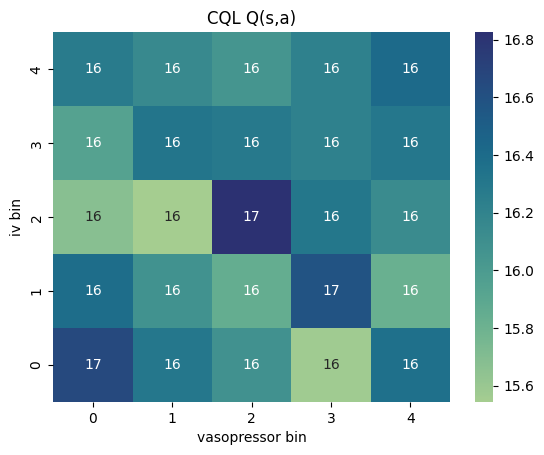

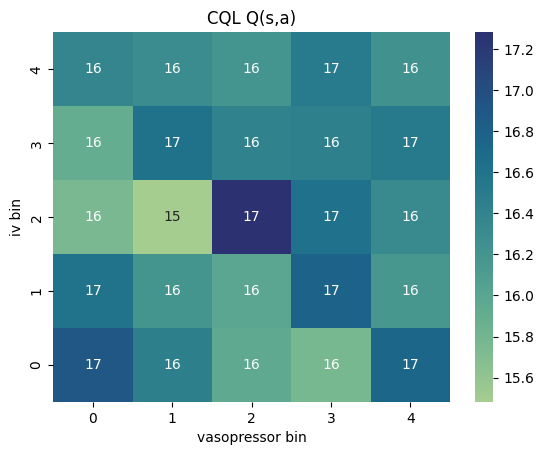

 30%|███████████▍                          | 2999/10000 [18:20<01:48, 64.72it/s]

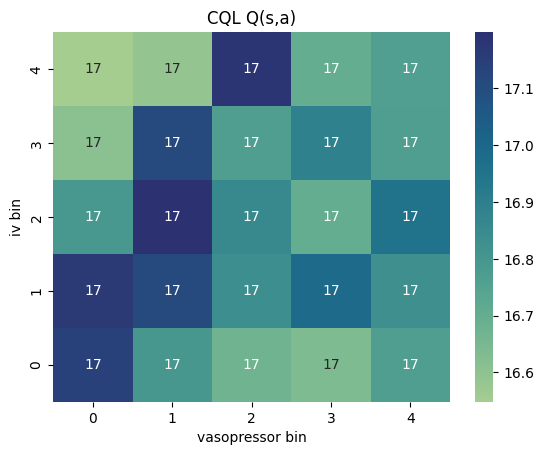

 40%|██████████████▍                     | 3996/10000 [32:21<1:42:38,  1.03s/it]

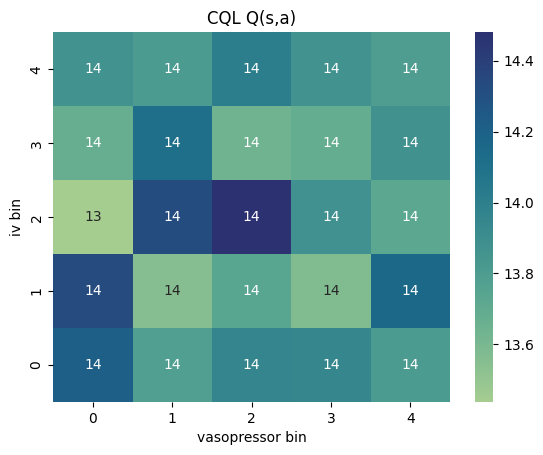

 50%|██████████████████▉                   | 4999/10000 [34:10<47:56,  1.74it/s]

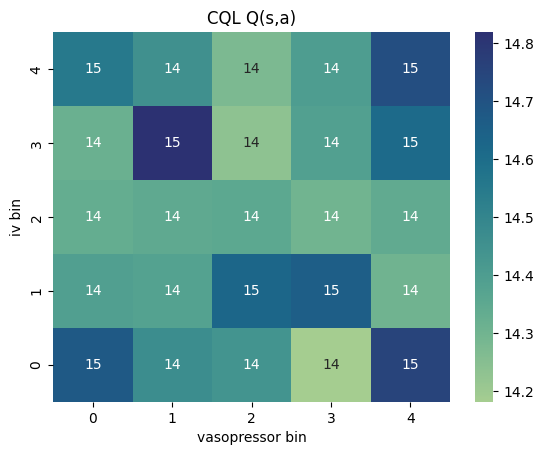

 60%|██████████████████████▊               | 5999/10000 [52:17<02:11, 30.53it/s]

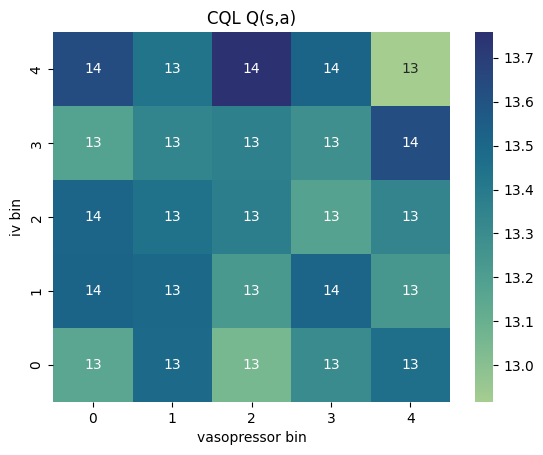

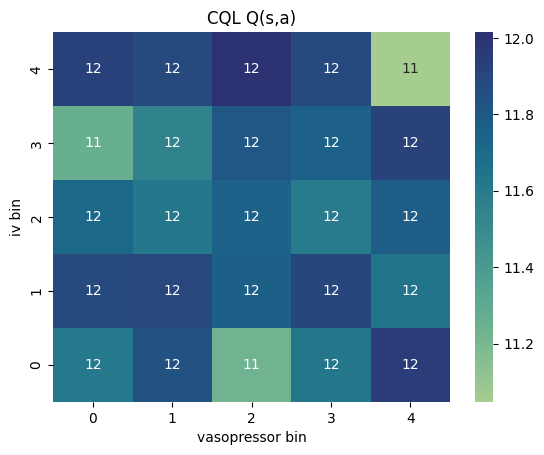

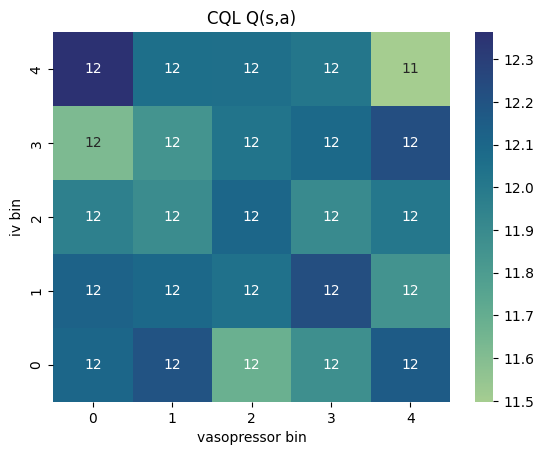

 70%|█████████████████████████▏          | 6994/10000 [1:40:57<00:44, 67.61it/s]

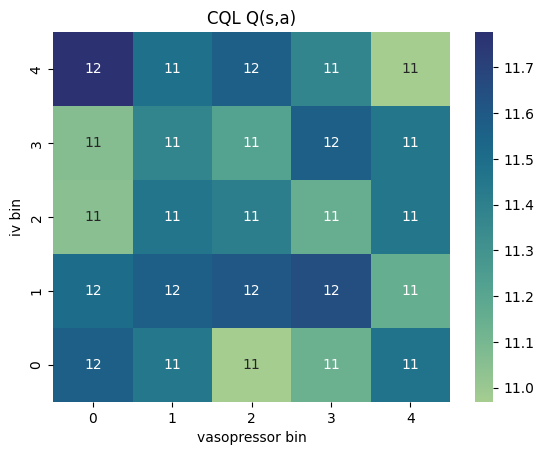

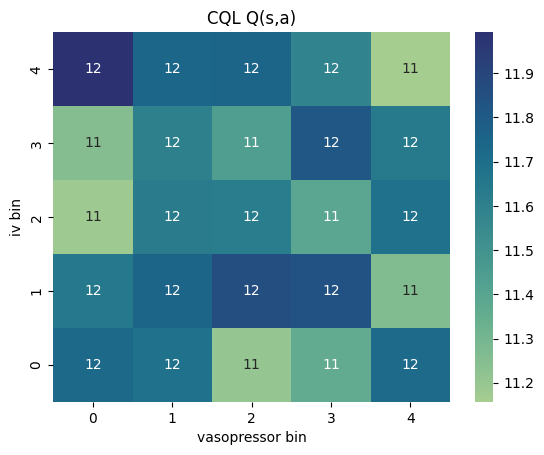

 80%|████████████████████████████▊       | 7997/10000 [1:43:31<00:36, 54.41it/s]

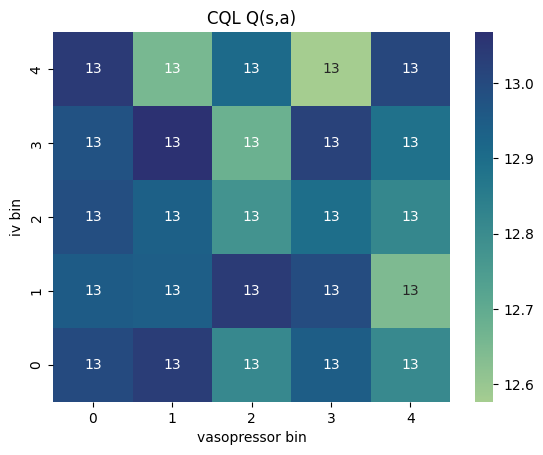

 90%|████████████████████████████████▍   | 8994/10000 [1:45:24<00:17, 58.10it/s]

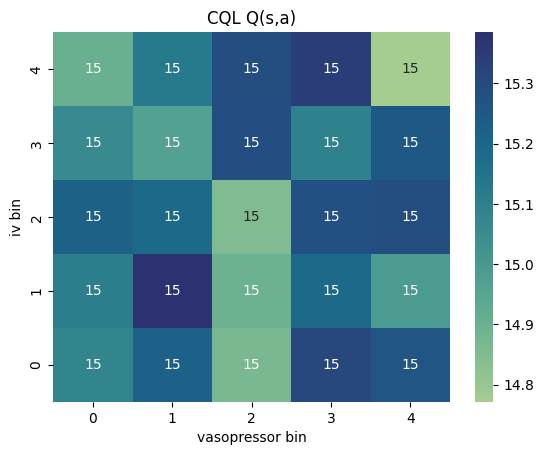

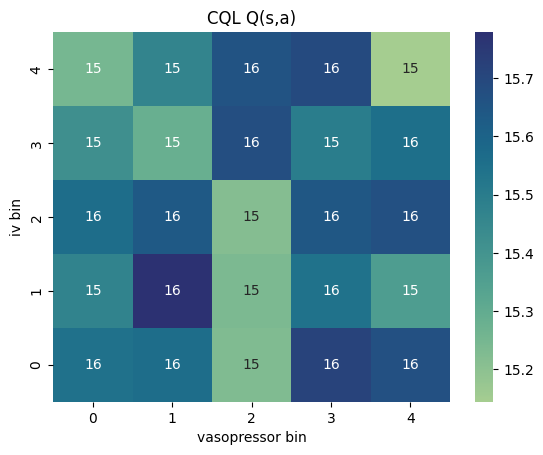

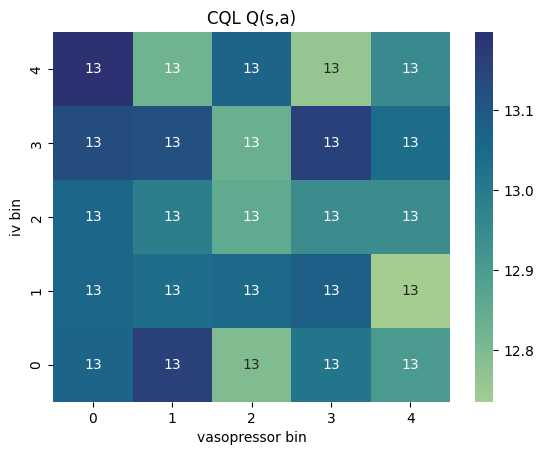

 93%|█████████████████████████████████▌  | 9329/10000 [1:56:29<00:10, 61.55it/s]

In [ ]:
### Conservative Q-Learning (CQL) -- with latent state space ###

cql_latent_agent = CQLAgent(latent_env.obs_dim, latent_env.action_dim)

# train policy
train_policy(cql_latent_agent, latent_env, model_name='CQL')

# save policy
torch.save(cql_agent.main_network.state_dict(), 'models/cql_latent_policy.pth')

# load policy
#cql_agent.main_network.load_state_dict(torch.load('models/cql_policy.pth'))

# evaluate policy
eval_policy(cql_latent_agent, latent_env, model_name='CQL')

In [ ]:
### Implicit Q-Learning (IQL) -- with full state space ###

iql_full_agent = IQLAgent(full_env.obs_dim, full_env.action_dim)

# train policy
train_policy(iql_full_agent, full_env, model_name='IQL')

# save policy
torch.save(iql_full_agent.actor.state_dict(), 'models/iql_full_policy.pth')

# load policy
#iql_agent.actor.load_state_dict(torch.load('models/iql_policy.pth'))

eval_policy(iql_full_agent, full_env, model_name='IQL')

In [ ]:
### Implicit Q-Learning (IQL) -- with latent state space ###

iql_latent_agent = IQLAgent(latent_env.obs_dim, latent_env.action_dim)

# train policy
train_policy(iql_latent_agent, latent_env, model_name='IQL')

# save policy
torch.save(iql_latent_agent.actor.state_dict(), 'models/iql_latent_policy.pth')

# load policy
#iql_agent.actor.load_state_dict(torch.load('models/iql_policy.pth'))

eval_policy(iql_latent_agent, latent_env, model_name='IQL')

In [11]:
### FQE ###

# evaluate physician policy
physician_fqe_val = off_policy_eval_fqe(train_df, sepsis_df, physician_policy)
print(f'{physician_fqe_val=}')

100%|██████████████████████████████████████| 3308/3308 [00:03<00:00, 858.11it/s]


physician_fqe_val=6.4860758781433105


In [8]:
# evaluate D3QN

d3qn_fqe_val = off_policy_eval_fqe(train_df, sepsis_df, d3qn_agent)
print(f'{d3qn_fqe_val=}')

100%|██████████████████████████████████████| 3308/3308 [00:03<00:00, 910.56it/s]


d3qn_fqe_val=3.115577220916748


In [9]:
# evaluate CQL
cql_fqe_val = off_policy_eval_fqe(train_df, sepsis_df, cql_agent)
print(f'{cql_fqe_val=}')

100%|██████████████████████████████████████| 3308/3308 [00:03<00:00, 919.21it/s]


cql_fqe_val=3.454349994659424


In [12]:
# evaluate IQL
iql_fqe_val = off_policy_eval_fqe(train_df, sepsis_df, iql_agent)
print(f'{iql_fqe_val=}')

100%|██████████████████████████████████████| 3308/3308 [00:03<00:00, 859.42it/s]


iql_fqe_val=5.254138946533203


In [8]:
### WIS ###

# evaluate D3QN
d3qn_wis_val = off_policy_eval_wis(sepsis_df, physician_policy, d3qn_agent)
print(f'{d3qn_wis_val=}')

d3qn_wis_val=0.0


In [8]:
# evaluate CQL

cql_wis_val = off_policy_eval_wis(sepsis_df, physician_policy, cql_agent)
print(f'{cql_wis_val=}')

cql_wis_val=-12.392529358924893


In [9]:
# evaluate IQL

iql_wis_val = off_policy_eval_wis(sepsis_df, physician_policy, iql_agent)
print(f'{iql_wis_val=}')

iql_wis_val=0.0


In [15]:
### DR ###

# evaluate D3QN
d3qn_dr_val = off_policy_eval_dr(sepsis_df, train_df, physician_policy, d3qn_agent)
print(f'{d3qn_dr_val=}')

100%|██████████████████████████████████████| 3308/3308 [00:03<00:00, 909.92it/s]


d3qn_dr_val=nan


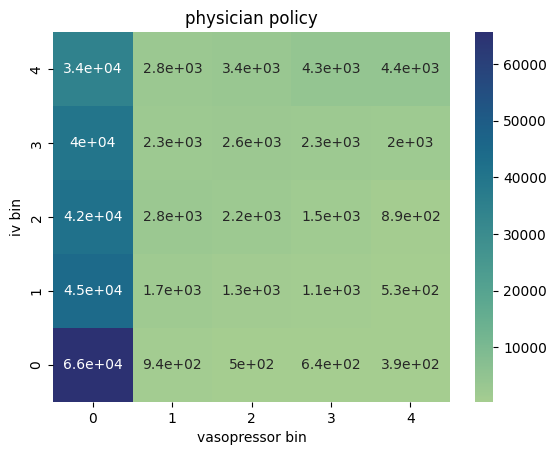

In [40]:
### Actual physician policy recorded in the data ###

df = pd.read_csv('data/sepsis_df.csv')

def get_action_log(df):
    action_log = np.zeros((5,5))
    for iv, vaso in zip(df['iv_bin'], df['vaso_bin']):
        action_log[(iv, vaso)] += 1
    return action_log

all_action_log = get_action_log(df)

fig, ax = plt.subplots()
policy_heatmap(all_action_log, 'physician', ax)

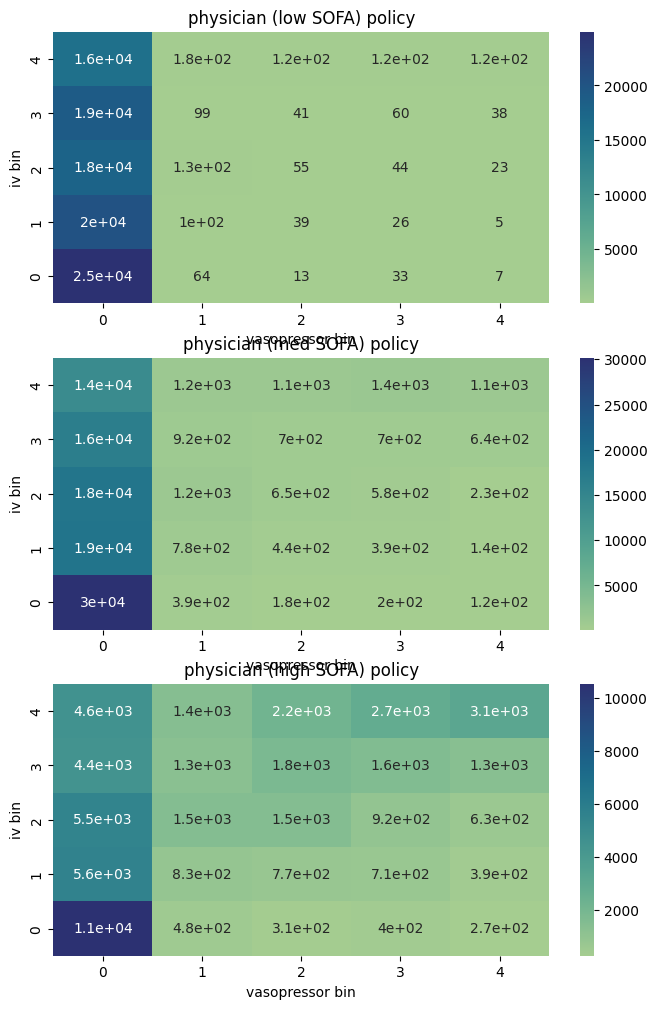

In [47]:
low_sofa_action_log = get_action_log(df[df['SOFA'] <= 4])
med_sofa_action_log = get_action_log(df[(df['SOFA'] > 4) & (df['SOFA'] <= 8)])
high_sofa_action_log = get_action_log(df[df['SOFA'] > 8])

fig, axs = plt.subplots(3, 1, figsize=(8,12))
policy_heatmap(low_sofa_action_log, 'physician (low SOFA)', axs[0])
policy_heatmap(med_sofa_action_log, 'physician (med SOFA)', axs[1])
policy_heatmap(high_sofa_action_log, 'physician (high SOFA)', axs[2])

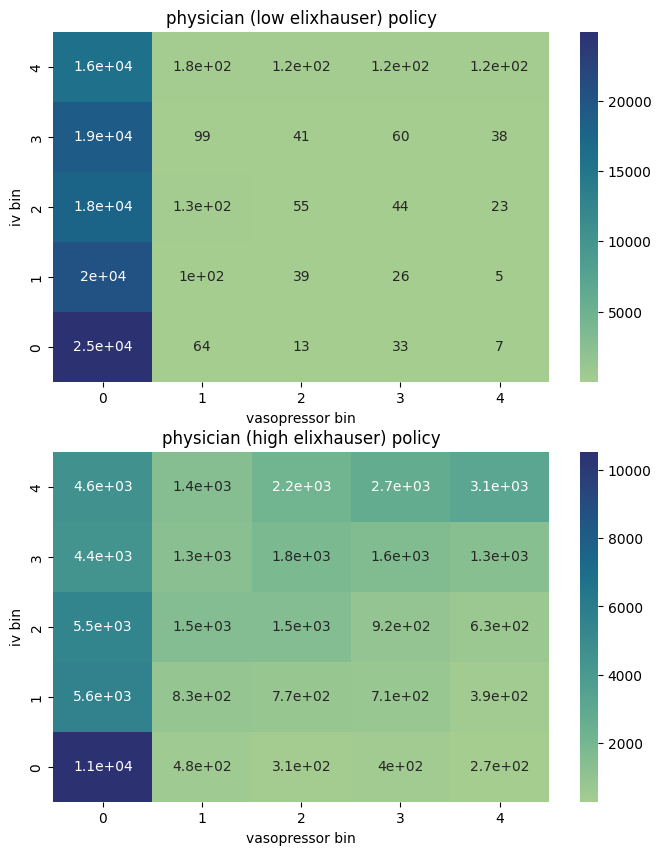

In [44]:
low_elixhauser_action_log = get_action_log(df[df['elixhauser'] < df['elixhauser'].mean()])
high_elixhauser_action_log = get_action_log(df[df['SOFA'] >= df['elixhauser'].mean()])

fig, axs = plt.subplots(2, 1, figsize=(8,10))
policy_heatmap(low_sofa_action_log, 'physician (low elixhauser)', axs[0])
policy_heatmap(high_sofa_action_log, 'physician (high elixhauser)', axs[1])

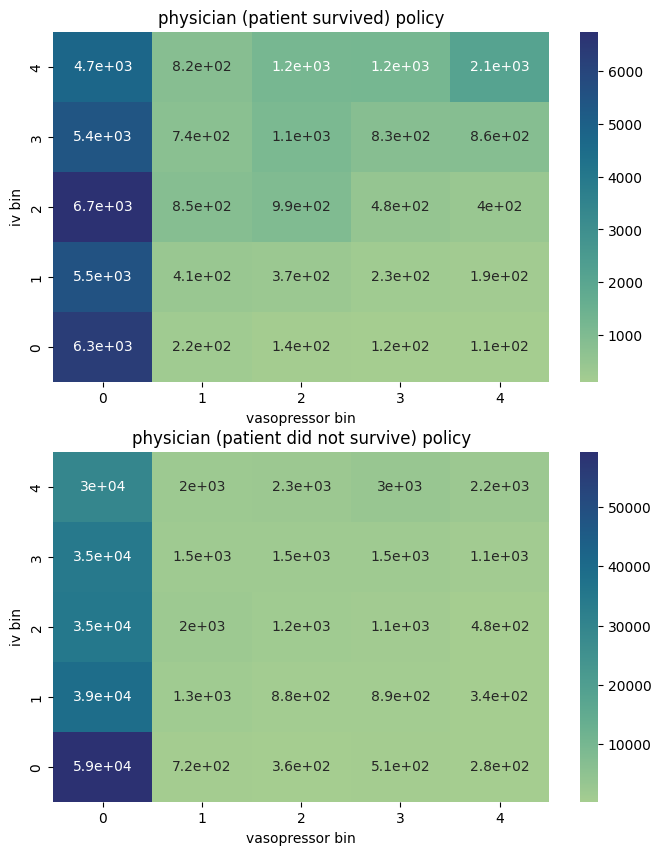

In [55]:
surv_action_log = get_action_log(df[df['died_in_hosp'] == 1])
died_action_log = get_action_log(df[df['died_in_hosp'] == 0])

fig, axs = plt.subplots(2, 1, figsize=(8,10))
policy_heatmap(surv_action_log, 'physician (patient survived)', axs[0])
policy_heatmap(died_action_log, 'physician (patient did not survive)', axs[1])